In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [3]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        new_feature = []
        for x in data:
            
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
            new_feature.append(classification)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes, np.array(new_feature)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
def R(y, y_pred):
    return 1 - np.var(y - y_pred) / np.var(y)

In [6]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction  

In [7]:
# Расчет качества

# критерий качества для регрессии
def regression_quality(left_labels, right_labels, current_var):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_var - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split_regression(data, labels, min_leaf):
    
    #  обозначим минимальное количество объектов в узле
    #min_leaf = 5

    current_var = np.var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = regression_quality(true_labels, false_labels, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree_regression(data, labels, min_leaf, max_depth, depth=0):

    quality, t, index = find_best_split_regression(data, labels, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0  or depth >= max_depth:
    #if quality == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    #depth +=1
    #print(depth)
    # Рекурсивно строим два поддерева
    true_branch = build_tree_regression(true_data, true_labels, min_leaf, max_depth, depth+1)
    false_branch = build_tree_regression(false_data, false_labels, min_leaf, max_depth, depth+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    
    return np.array([sum([eta* coef * predict([x], alg)[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [13]:
def mean_squared_error(y_real, prediction):
    #print(y_real)
    return (sum((y_real - prediction)**2)) / len(y_real)

In [14]:
def bias(y, z):
      
    return (y - z)

In [15]:
def gb_fit(n_trees, min_leafs, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        #tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        batch_ind = np.random.choice(list(range(X_train.shape[0])), X_train.shape[0] // 10, replace=False)
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree = build_tree_regression(X_train, y_train, min_leafs, max_depth)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            #max_depth = np.random.randint(1, 15)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree = build_tree_regression(X_train, bias(y_train, target), min_leafs, max_depth)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        
        trees.append(tree)
        
        if np.abs(test_errors[i] - test_errors[i-1]) < 0.001 and i > 1:
            
            break
        
    return trees, train_errors, test_errors

In [16]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [17]:
def gb_predict__(X, y, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    for x in X:
        
        for tree, coef in zip(trees_list, coef_list):
            pred_temp = predict(x, tree)
            
            
    return W

# Итоговая работа по курсу "Алгоритмы анализа данных" (задача регрессия)

Для решения задачи был выбран алгоритм градиентного бустинга из методичек с незначительными изменениями. В качестве дерева решений так же используется дерево из методички, вместо готовых библиотек.

In [18]:
data = pd.read_csv('train.csv')

In [19]:
data.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,0,40.0,0.0,1400.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,63.0
1,1,48.0,4.0,2850.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,86.0
2,2,39.0,0.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
3,3,46.0,5.0,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
4,4,43.0,1.0,1500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0


Возникла идея улучшить модель, сформировав дополнительный признак на основе алгоритма K-means (переменные по ошибке содержат название Knn) <br>
Данный шаг предпринимался как последняя попытка улучшить модель, что дало прирост с ~0.78 до ~0.781

In [20]:
X_knn = data[['age', 'years_of_experience', 'lesson_price', 'qualification']]
X_knn.tail(3)

,age,years_of_experience,lesson_price,qualification
9997,34.0,1.0,1250.0,1.0
9998,33.0,3.0,1100.0,1.0
9999,35.0,0.0,1450.0,1.0


In [21]:
X_knn = np.array(X_knn)

In [22]:
y = np.array(data['mean_exam_points'])
data.drop(['Id', 'mean_exam_points'], axis=1, inplace=True)

In [23]:
X = np.array(data)

In [24]:
# определим максимальное количество итераций
max_iterations = 3

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

centroids, clusters, new_feature = kmeans(X, k, max_iterations, min_distance)

In [25]:
data.shape, y.shape

((10000, 10), (10000,))

In [26]:
X = np.hstack((X, np.atleast_2d(new_feature).T))

In [27]:
X.shape, new_feature.shape

((10000, 11), (10000,))

In [28]:
train_data, test_data, train_values, test_values = train_test_split(X, y, 
                                                                        test_size = 0.3,
                                                                        random_state = 22)

In [29]:
train_data

array([[  43.,    0., 1700., ...,    0.,    0.,    0.],
       [  52.,    5., 1550., ...,    0.,    0.,    0.],
       [  52.,    0., 1300., ...,    0.,    0.,    2.],
       ...,
       [  51.,    0., 1450., ...,    0.,    0.,    0.],
       [  43.,    0., 1450., ...,    0.,    0.,    0.],
       [  41.,    2., 1350., ...,    0.,    0.,    2.]])

Теперь, когда окончательный набор признаков сформирован, пробуем подобрать оптимальное значение min_leafs (минимальное количество объектов в узле) и максимальную глубину дерева.

In [30]:
my_tree_regr = build_tree_regression(train_data, train_values, 1, 2)

In [31]:
train_pred = predict(train_data, my_tree_regr)
test_pred = predict(test_data, my_tree_regr)

In [32]:
R(test_values, test_pred)

0.6534584076942729

In [33]:
leafs = list(range(1, 21))
r_score = [[],[]]
for i in leafs:
    my_tree_regr = build_tree_regression(train_data, train_values, i, 10)
    train_pred = predict(train_data, my_tree_regr)
    test_pred = predict(test_data, my_tree_regr)
    r_score[0].append(R(train_values, train_pred))
    r_score[1].append(R(test_values, test_pred)) 

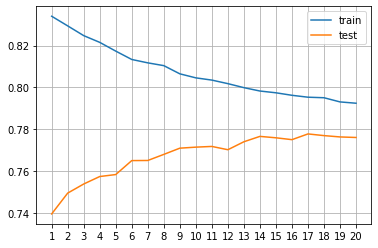

In [34]:
plt.plot(leafs, r_score[0], label='train')
plt.plot(leafs, r_score[1], label='test')
plt.legend()
plt.xticks(leafs)
plt.grid()
plt.show()

Аналогично подбираем глубину дерева

In [35]:
depth = list(range(5, 20))
r_score = [[],[]]
for i in depth:
    my_tree_regr = build_tree_regression(train_data, train_values, 14, i)
    train_pred = predict(train_data, my_tree_regr)
    test_pred = predict(test_data, my_tree_regr)
    r_score[0].append(R(train_values, train_pred))
    r_score[1].append(R(test_values, test_pred))

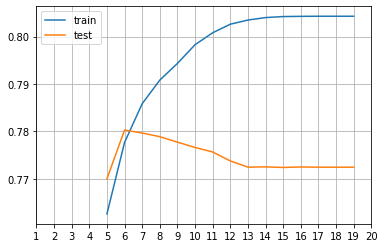

In [36]:
plt.plot(depth, r_score[0], label='train')
plt.plot(depth, r_score[1], label='test')
plt.legend()
plt.xticks(leafs)
plt.grid()
plt.show()

Теперь попробуем построить модель с найденными параметрами. Количество деревьев задано максимально допустимым, но на практике строится меньше, поскольку добавлен критерий останова

In [37]:
# Число деревьев в ансамбле
n_trees = 150

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees
min_leafs = 17
max_depth = 6
# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, min_leafs, max_depth, train_data, test_data, train_values, test_values, coefs, eta)

In [38]:
len(test_errors) # количество деревьев, которые были построены

48

In [39]:
test_errors.index(min(test_errors)), min(test_errors) #индекс дерева с минимальной ошибкой, и минимальная ошибка

(47, 39.67801862506478)

In [40]:
y_pred = gb_predict(test_data, trees, coefs, eta)

In [41]:
R(test_values, y_pred)

0.7890979118538828

Результат работы данного алгоритма после подбора всех параметров на Kaggle равнялся ~0.75

#### Кросс-валидация <br>
точнее то, как я её понял

Мы имеем 10 000 наблюдений в нашем датасете. Соответственно, мы разбиваем эти данные на 1 000 для тестовых данных, и 9 000 для обучающих. Мы можем сделать это 10 раз таким образом, чтобы тестовые выборки всегда были уникальны. Получается, что мы можем построить и проверить 10 разных моделей, убедиться что ошибки на тестовой выборке приемлимы, после чего для эти модели "проголосуют" и дадут более точный итоговый результат. <br>
Изначально пробовал разбивать данные в соотношении 2/8, 25/75, однако именно 1/9 дало самый высокий балл на kaggle. 

In [43]:
X_part = X.copy()

In [44]:
X_part.shape

(10000, 11)

In [46]:
valid_size = 1000

In [47]:
# Число деревьев в ансамбле
n_trees = 100

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees
min_leafs = 17
max_depth = 6
# Шаг
eta = 0.1


final_model = []
final_train_errors = []
final_test_errors = []
for i in range(10):
    indexes = list(range(i*valid_size, i*valid_size + valid_size - 1))
    X_train_part = X.copy()
    X_train_part = np.delete(X_train_part, indexes, axis=0)
    y_train_part = y.copy()
    y_train_part = np.delete(y_train_part, indexes, axis=0)
    X_test_part = X[indexes].copy()    
    y_test_part = y[indexes].copy()
    trees, train_errors, test_errors = gb_fit(n_trees, min_leafs, max_depth, X_train_part, 
                                              X_test_part, y_train_part, y_test_part, coefs, eta)
    final_model.append(trees)
    final_train_errors.append(train_errors)
    final_test_errors.append(test_errors)
    
    

Выведем ошибки по полученным моделям и количество деревьев в каждой из них

In [48]:
[(min(err)) for err in final_test_errors], [err.index(min(err)) for err in final_test_errors]

([39.657763462837536,
  37.691169566861426,
  38.566371750570674,
  41.44133729410962,
  41.56263170185184,
  41.362735270560535,
  37.908819831670584,
  39.50903741239638,
  42.7588500721642,
  39.82505236723492],
 [54, 62, 50, 60, 53, 53, 76, 68, 71, 62])

Возникла идея выбрать "хорошие" модели, с минимальными ошибками, и дать право голоса только им. На практике такой подход дал менее хороший результат на kaggle

In [49]:
good_models = []
errr = [(min(err)) for err in final_test_errors]
for i in range(len(errr)):
    if errr[i] < 40:
        good_models.append(i)
good_models

[0, 1, 2, 6, 7, 9]

In [50]:
y_final_pred = []

for i in good_models:
    #print(i)
    y_final_pred.append(gb_predict(test_data, final_model[i], coefs, eta))

In [51]:
y_final_pred = np.mean(y_final_pred, axis=0)

In [52]:
R(test_values, y_final_pred)

0.8129939865738315

In [53]:
y_final_pred = []

for i in final_model:
    
    y_final_pred.append(gb_predict(test_data, i, coefs, eta))


In [54]:
y_final_pred = np.mean(y_final_pred, axis=0)

In [55]:
R(test_values, y_final_pred) 

0.8131068711872653

Дальше просто повторяем нужные операции над данными для сабмита и загружаем результат на kaggle

In [56]:
data_pred = pd.read_csv('test.csv')

In [57]:
submission_data = data_pred.copy()
data_pred.drop('Id', axis=1, inplace=True)

In [58]:
X_pred_knn = data_pred[['age', 'years_of_experience', 'lesson_price', 'qualification']]
#X_pred_knn['age'] = X_pred_knn['age'] / 10
#X_pred_knn['lesson_price'] = X_pred_knn['lesson_price'] / 1000
X_pred_knn = np.array(X_pred_knn)

In [59]:
data_pred = np.array(data_pred)

In [60]:
data_pred.shape

(10000, 10)

In [61]:
# определим максимальное количество итераций
max_iterations = 3

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

centroids, clusters, new_feature = kmeans(X_pred_knn, k, max_iterations, min_distance)

In [62]:
data_pred = np.hstack((data_pred, np.atleast_2d(new_feature).T))

In [63]:
data_pred.shape

(10000, 11)

Итоговый рост качества до 0.78 произошел именно при голосовании всех моделей

In [64]:
y_final_pred = []

for model in final_model:
    
    y_final_pred.append(gb_predict(data_pred, model, coefs, eta))

In [65]:
y_final_pred = np.mean(y_final_pred, axis=0)

In [66]:
y_commit = y_final_pred

In [67]:
#y_commit = np.around(y_commit)

In [68]:
submission = pd.concat([submission_data['Id'], pd.Series(y_commit)], axis=1)

In [69]:
submission = submission.rename(columns={0: 'mean_exam_points'})

In [70]:
submission.to_csv('Babalich_lastround.csv',index=None)

In [71]:
submission

,Id,mean_exam_points
0,10000,54.767366
1,10001,62.706088
2,10002,48.317900
3,10003,92.160378
4,10004,88.958866
5,10005,62.774863
6,10006,41.680934
7,10007,53.248122
8,10008,57.843669
9,10009,79.411807
